In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

In [15]:
df = pd.read_csv('total_data.csv')
df.head()

,period,total_value,differenced
0,2019-01-01,465701,NaN
1,2019-01-02,488901,23200.0
2,2019-01-03,484062,-4839.0
3,2019-01-04,477305,-6757.0
4,2019-01-05,451001,-26304.0


In [16]:
df.dtypes

period          object
total_value      int64
differenced    float64
dtype: object

In [17]:
# Convert 'date' column to datetime and set it as index
df['date'] = pd.to_datetime(df['period'])
df.set_index('date', inplace=True)
# Delete differenced column
df.drop(columns=['differenced','period'], inplace=True)

In [40]:
df.rename(columns={'total_value': 'value'}, inplace=True)
df.head()

,value
date,
2019-01-01,465701
2019-01-02,488901
2019-01-03,484062
2019-01-04,477305
2019-01-05,451001


## 7-Day ahead Forecast


Target variable is stationary (p-value: 0.0242)

Data split:
Training: 2019-01-01 to 2025-12-03 (2529 samples)
Testing: 2025-12-04 to 2025-12-10 (7 samples)

Starting Grid Search with Time Series Cross-Validation
Total parameter combinations: 144
Running 3-fold CV for each combination...
Running parallel evaluation with 11 cores...


/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473


Best parameters found:
  Order: (1, 1, 0)
  Seasonal Order: (1, 0, 1, 7)
  Best RMSE: 32638.658

Top 10 parameter combinations (by RMSE):
    order seasonal_order      rmse       mae  mape
(1, 1, 0)   (1, 0, 1, 7) 32638.658 26955.107 4.734
(0, 1, 1)   (1, 0, 1, 7) 32651.055 26937.810 4.730
(1, 1, 1)   (1, 0, 1, 7) 32651.163 26938.151 4.730
(2, 1, 0)   (1, 0, 1, 7) 33005.073 27013.564 4.737
(0, 1, 2)   (1, 0, 1, 7) 33034.592 27069.020 4.746
(2, 1, 1)   (1, 0, 1, 7) 33187.141 26660.565 4.674
(0, 1, 0)   (1, 0, 1, 7) 33440.239 27437.706 4.807
(1, 1, 0)   (0, 1, 1, 7) 34156.350 28476.657 5.006
(2, 1, 2)   (0, 1, 1, 7) 34159.507 28224.808 4.973
(0, 1, 1)   (0, 1, 1, 7) 34203.589 28508.621 5.011

Training Final Model with Best Parameters
                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                 2529
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood      

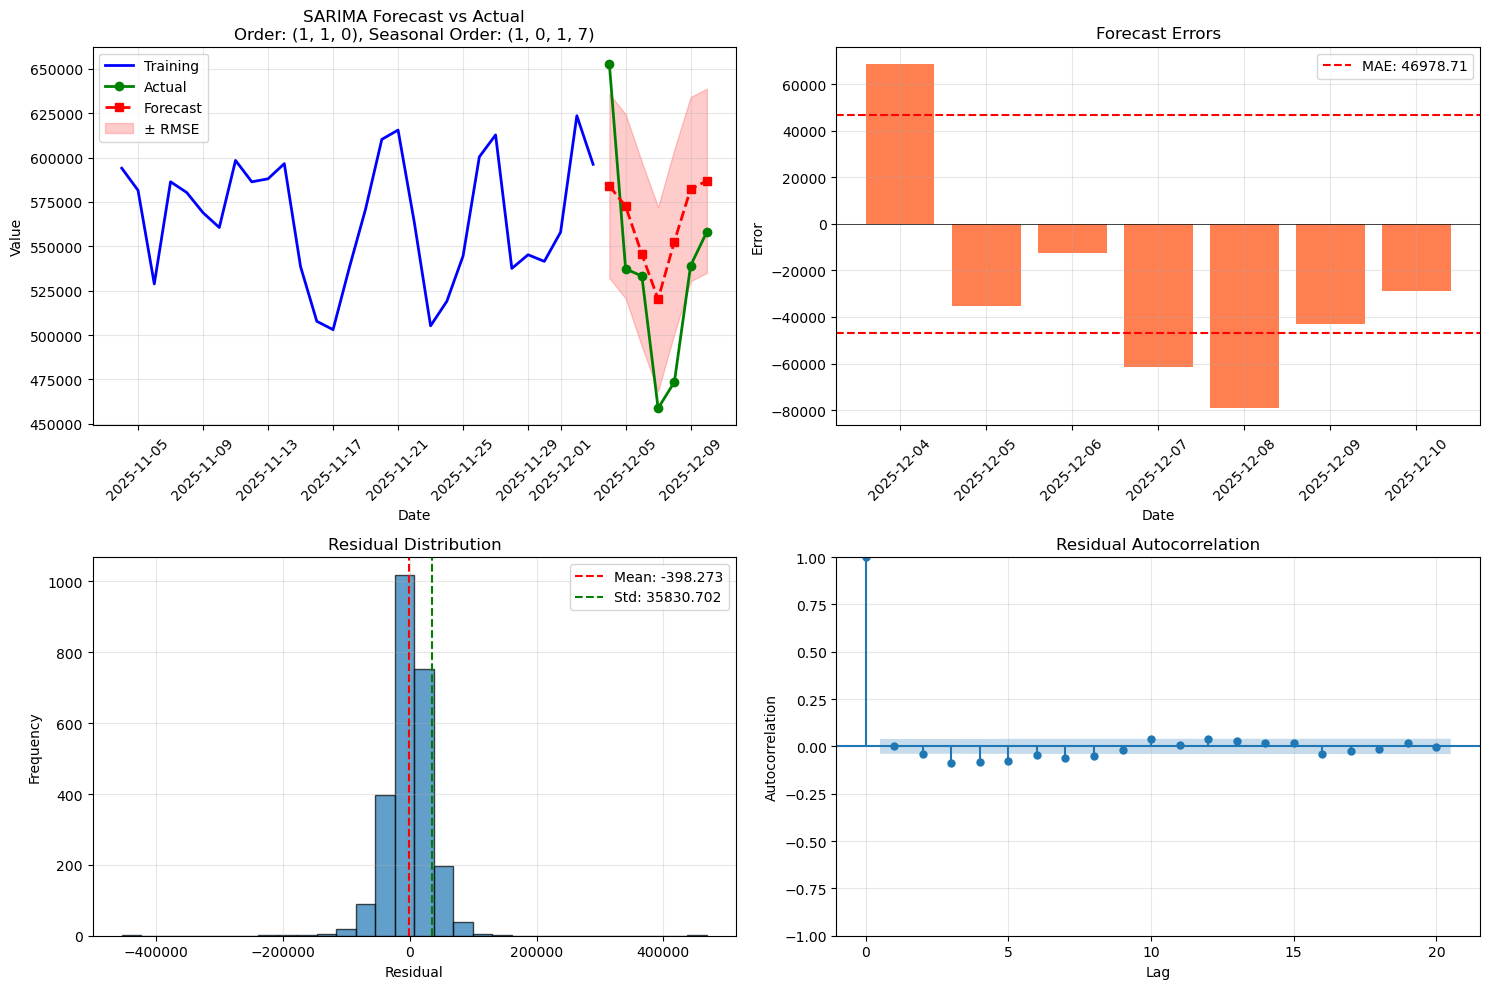


Detailed Forecast Results:
                 Date  Actual    Forecast      Error  Error_Percent
date                                                               
2025-12-04 2025-12-04  652778  584043.089  68734.911         10.530
2025-12-05 2025-12-05  537292  572575.290 -35283.290         -6.567
2025-12-06 2025-12-06  533249  545583.992 -12334.992         -2.313
2025-12-07 2025-12-07  458778  520225.014 -61447.014        -13.394
2025-12-08 2025-12-08  473492  552700.487 -79208.487        -16.729
2025-12-09 2025-12-09  539159  582224.614 -43065.614         -7.988
2025-12-10 2025-12-10  558180  586956.690 -28776.690         -5.155

Making Future Forecasts (Next 7 Days)
Future Forecasts with 95% Confidence Intervals:
                 Date    Forecast    Lower_CI    Upper_CI
2025-12-04 2025-12-11  584043.089  501760.088  666326.089
2025-12-05 2025-12-12  572575.290  451639.460  693511.121
2025-12-06 2025-12-13  545583.992  395359.379  695808.605
2025-12-07 2025-12-14  520225.014  345536

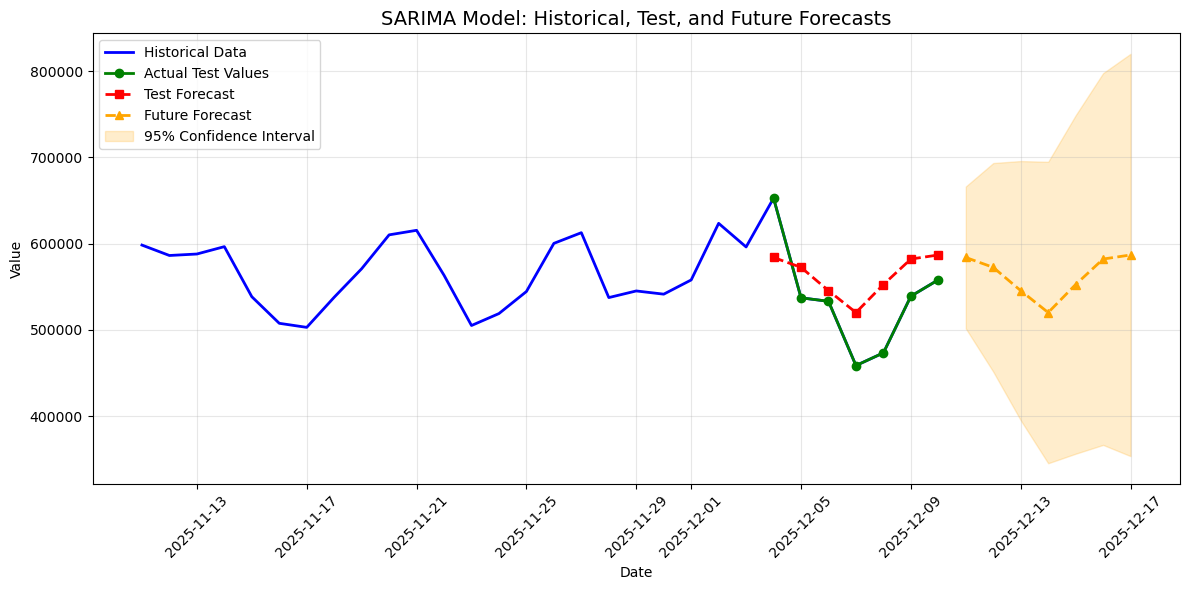


Time Series Decomposition


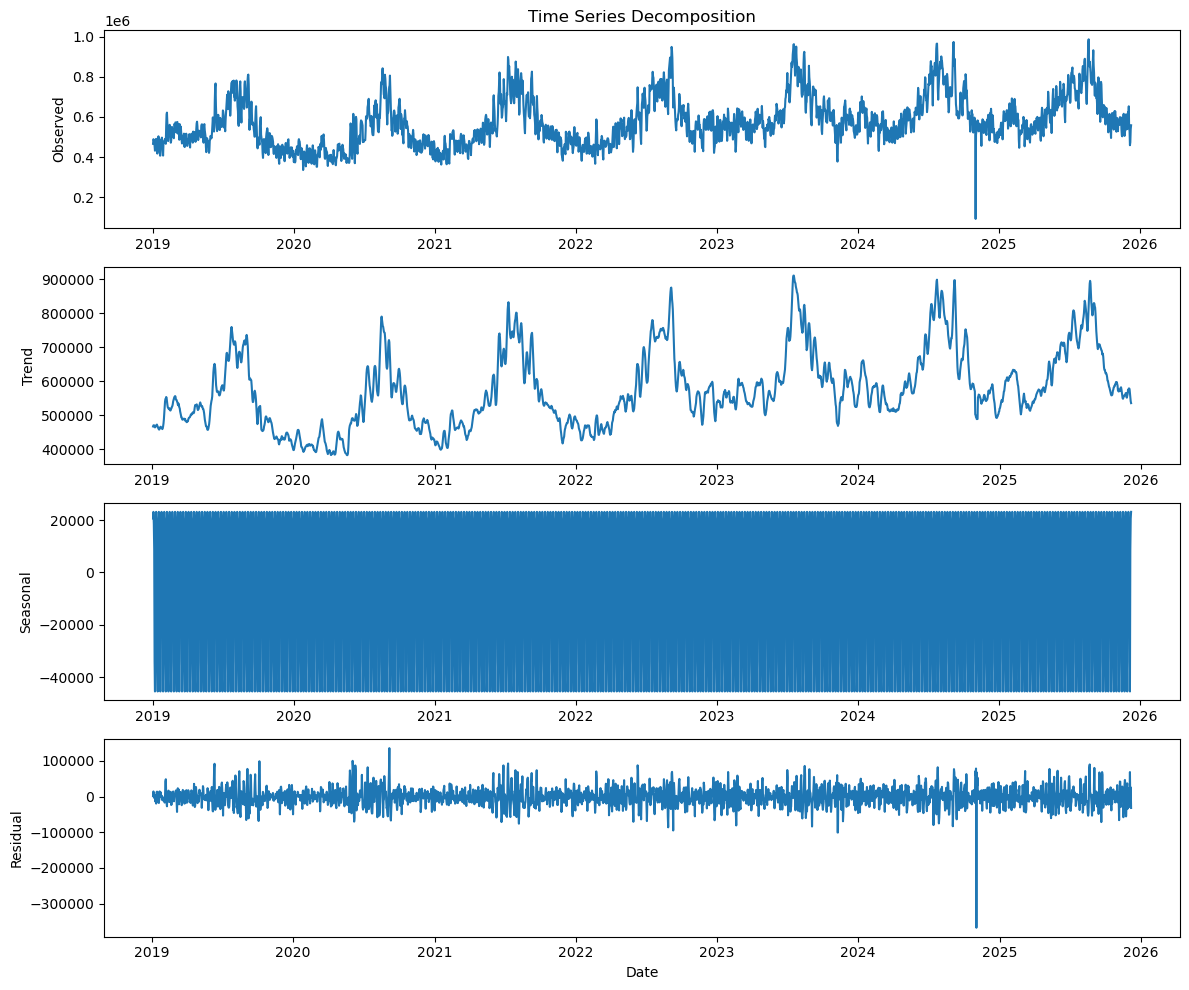

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from joblib import Parallel, delayed
import multiprocessing

# Function to check stationarity
def check_stationarity(series):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    result = adfuller(series)
    is_stationary = result[1] <= 0.05
    return is_stationary, result[1]

# Check stationarity of target variable
is_stationary, p_value = check_stationarity(df['value'])
print(f"\nTarget variable is {'stationary' if is_stationary else 'non-stationary'} (p-value: {p_value:.4f})")

# Time Series Cross-Validation Function for SARIMA
def time_series_cv_sarima(data, target_col, order, seasonal_order, 
                          n_splits=5, test_size=7, verbose=False):
    """
    Perform time series cross-validation for SARIMA model
    """
    n_samples = len(data)
    cv_scores = {
        'mae': [],
        'mse': [],
        'rmse': [],
        'mape': []
    }
    
    # Calculate starting point for splits (ensure enough training data)
    min_train_size = n_samples - (n_splits * test_size)
    
    for i in range(n_splits):
        # Define train-test split for this fold
        test_start = min_train_size + i * test_size
        test_end = test_start + test_size
        
        train_data = data.iloc[:test_start]
        test_data = data.iloc[test_start:test_end]
        
        if verbose:
            print(f"\nFold {i+1}/{n_splits}:")
            print(f"  Train: {train_data.index[0].date()} to {train_data.index[-1].date()} "
                  f"({len(train_data)} samples)")
            print(f"  Test: {test_data.index[0].date()} to {test_data.index[-1].date()} "
                  f"({len(test_data)} samples)")
        
        try:
            # Fit SARIMA model (SARIMAX without exogenous variables)
            model = SARIMAX(
                train_data[target_col],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            model_fit = model.fit(disp=False)
            
            # Forecast on test set
            forecast = model_fit.forecast(steps=len(test_data))
            
            # Calculate metrics
            actual = test_data[target_col].values
            pred = forecast.values
            
            # Handle zero values for MAPE
            mask = actual != 0
            if mask.any():
                mape = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100
            else:
                mape = np.nan
            
            mae = mean_absolute_error(actual, pred)
            mse = mean_squared_error(actual, pred)
            rmse = np.sqrt(mse)
            
            cv_scores['mae'].append(mae)
            cv_scores['mse'].append(mse)
            cv_scores['rmse'].append(rmse)
            cv_scores['mape'].append(mape)
            
            if verbose:
                print(f"  MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%")
                
        except Exception as e:
            if verbose:
                print(f"  Error in fold {i+1}: {str(e)}")
            # Assign high error scores for failed fits
            cv_scores['mae'].append(np.inf)
            cv_scores['mse'].append(np.inf)
            cv_scores['rmse'].append(np.inf)
            cv_scores['mape'].append(np.inf)
    
    # Calculate average scores
    avg_scores = {}
    for metric in cv_scores:
        valid_scores = [score for score in cv_scores[metric] if not np.isinf(score)]
        if valid_scores:
            avg_scores[metric] = np.mean(valid_scores)
        else:
            avg_scores[metric] = np.inf
    
    return avg_scores

# Grid Search Function with Parallel Processing
def grid_search_sarima(data, target_col, 
                      p_range, d_range, q_range,
                      P_range, D_range, Q_range, s_values,
                      n_splits=3, test_size=7,
                      metric='rmse', n_jobs=-1,
                      verbose=1):
    """
    Perform grid search for SARIMA hyperparameters with parallel processing
    """
    # Generate all parameter combinations
    non_seasonal_params = list(itertools.product(p_range, d_range, q_range))
    seasonal_params = list(itertools.product(P_range, D_range, Q_range))
    
    all_params = []
    for ns in non_seasonal_params:
        for ss in seasonal_params:
            for s in s_values:
                all_params.append((ns, ss, s))
    
    if verbose >= 1:
        print(f"Total parameter combinations: {len(all_params)}")
        print(f"Running {n_splits}-fold CV for each combination...")
    
    # Function to evaluate a single parameter set
    def evaluate_params(params):
        order, seasonal, s = params
        P, D, Q = seasonal
        seasonal_order = (P, D, Q, s)
        
        try:
            scores = time_series_cv_sarima(
                data, target_col,
                order, seasonal_order,
                n_splits=n_splits,
                test_size=test_size,
                verbose=False
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'mae': scores['mae'],
                'mse': scores['mse'],
                'rmse': scores['rmse'],
                'mape': scores['mape'],
                'success': True
            }
        except Exception as e:
            if verbose >= 2:
                print(f"Failed for params {order}, {seasonal_order}: {str(e)[:50]}...")
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'mae': np.inf,
                'mse': np.inf,
                'rmse': np.inf,
                'mape': np.inf,
                'success': False
            }
    
    # Run evaluations in parallel
    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()
    
    if verbose >= 1:
        print(f"Running parallel evaluation with {n_jobs} cores...")
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_params)(params) for params in all_params
    )
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter out failed runs
    valid_results = results_df[results_df['success']]
    
    if len(valid_results) == 0:
        print("Warning: No successful model fits!")
        return results_df, None
    
    # Find best parameters based on chosen metric
    if metric in valid_results.columns:
        best_idx = valid_results[metric].idxmin()
        best_params = {
            'order': valid_results.loc[best_idx, 'order'],
            'seasonal_order': valid_results.loc[best_idx, 'seasonal_order'],
            'score': valid_results.loc[best_idx, metric]
        }
        
        if verbose >= 1:
            print(f"\nBest parameters found:")
            print(f"  Order: {best_params['order']}")
            print(f"  Seasonal Order: {best_params['seasonal_order']}")
            print(f"  Best {metric.upper()}: {best_params['score']:.3f}")
    
    return results_df, best_params

# Split data for final evaluation
test_size = 7
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print(f"\nData split:")
print(f"Training: {train_data.index[0].date()} to {train_data.index[-1].date()} "
      f"({len(train_data)} samples)")
print(f"Testing: {test_data.index[0].date()} to {test_data.index[-1].date()} "
      f"({len(test_data)} samples)")

# Perform Grid Search with CV
print("\n" + "="*60)
print("Starting Grid Search with Time Series Cross-Validation")
print("="*60)

# Define parameter ranges (keep small for demonstration)
p_range = range(0, 3)  # AR order
d_range = range(0, 2)  # Differencing
q_range = range(0, 3)  # MA order

P_range = range(0, 2)  # Seasonal AR
D_range = range(0, 2)  # Seasonal differencing
Q_range = range(0, 2)  # Seasonal MA
s_values = [7]         # Weekly seasonality

# Run grid search
results_df, best_params = grid_search_sarima(
    data=train_data,
    target_col='value',
    p_range=p_range,
    d_range=d_range,
    q_range=q_range,
    P_range=P_range,
    D_range=D_range,
    Q_range=Q_range,
    s_values=s_values,
    n_splits=3,      # Number of CV folds
    test_size=7,     # Forecast horizon for CV
    metric='rmse',   # Metric to optimize
    n_jobs=-1,       # Use all cores
    verbose=1
)

# Display top 10 parameter combinations
if results_df is not None and len(results_df) > 0:
    valid_results = results_df[results_df['success']].copy()
    if len(valid_results) > 0:
        print(f"\nTop 10 parameter combinations (by RMSE):")
        top_results = valid_results.nsmallest(10, 'rmse')[['order', 'seasonal_order', 'rmse', 'mae', 'mape']]
        print(top_results.round(3).to_string(index=False))
    else:
        print("No valid results to display.")

# Train final model with best parameters
if best_params:
    print("\n" + "="*60)
    print("Training Final Model with Best Parameters")
    print("="*60)
    
    # Fit final model on all training data
    final_model = SARIMAX(
        train_data['value'],
        order=best_params['order'],
        seasonal_order=best_params['seasonal_order'],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    final_fit = final_model.fit(disp=False)
    print(final_fit.summary())
    
    # Forecast on test set
    test_forecast = final_fit.forecast(steps=len(test_data))
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': test_data.index,
        'Actual': test_data['value'],
        'Forecast': test_forecast.values,
        'Error': test_data['value'] - test_forecast.values
    })
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(forecast_df['Actual'], forecast_df['Forecast'])
    mse = mean_squared_error(forecast_df['Actual'], forecast_df['Forecast'])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(forecast_df['Error'] / forecast_df['Actual'])) * 100
    
    print(f"\nFinal Model Performance on Test Set:")
    print(f"MAE:  {mae:.3f}")
    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Forecast vs Actual
    axes[0, 0].plot(train_data.index[-30:], train_data['value'][-30:], 
                   label='Training', color='blue', linewidth=2)
    axes[0, 0].plot(forecast_df['Date'], forecast_df['Actual'], 
                   label='Actual', color='green', marker='o', linewidth=2)
    axes[0, 0].plot(forecast_df['Date'], forecast_df['Forecast'], 
                   label='Forecast', color='red', linestyle='--', marker='s', linewidth=2)
    axes[0, 0].fill_between(forecast_df['Date'],
                           forecast_df['Forecast'] - rmse,
                           forecast_df['Forecast'] + rmse,
                           alpha=0.2, color='red', label='± RMSE')
    axes[0, 0].set_title(f'SARIMA Forecast vs Actual\nOrder: {best_params["order"]}, '
                        f'Seasonal Order: {best_params["seasonal_order"]}', fontsize=12)
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Forecast Errors
    axes[0, 1].bar(forecast_df['Date'], forecast_df['Error'], color='coral')
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].axhline(y=mae, color='red', linestyle='--', label=f'MAE: {mae:.2f}')
    axes[0, 1].axhline(y=-mae, color='red', linestyle='--')
    axes[0, 1].set_title('Forecast Errors', fontsize=12)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Error')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Residual Diagnostics
    residuals = final_fit.resid
    axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=residuals.mean(), color='red', linestyle='--', 
                      label=f'Mean: {residuals.mean():.3f}')
    axes[1, 0].axvline(x=residuals.std(), color='green', linestyle='--', 
                      label=f'Std: {residuals.std():.3f}')
    axes[1, 0].set_title('Residual Distribution', fontsize=12)
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(residuals, lags=20, ax=axes[1, 1])
    axes[1, 1].set_title('Residual Autocorrelation', fontsize=12)
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display detailed forecast table
    print("\nDetailed Forecast Results:")
    forecast_df['Error_Percent'] = (forecast_df['Error'] / forecast_df['Actual']) * 100
    print(forecast_df.round(3))
    
    # Make future forecasts (next 7 days beyond available data)
    print("\n" + "="*60)
    print("Making Future Forecasts (Next 7 Days)")
    print("="*60)
    
    # Create future dates
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
    
    # Make future forecasts
    future_forecast = final_fit.forecast(steps=7)
    
    # Get confidence intervals from the forecast object
    forecast_obj = final_fit.get_forecast(steps=7)
    conf_int = forecast_obj.conf_int()
    
    future_df = pd.DataFrame({
        'Date': future_dates,
        'Forecast': future_forecast.values,
        'Lower_CI': conf_int.iloc[:, 0],
        'Upper_CI': conf_int.iloc[:, 1]
    })
    
    print("Future Forecasts with 95% Confidence Intervals:")
    print(future_df.round(3))
    
    # Plot historical data, test forecasts, and future forecasts
    plt.figure(figsize=(12, 6))
    
    # Plot historical data
    plt.plot(df.index[-30:], df['value'][-30:], label='Historical Data', color='blue', linewidth=2)
    
    # Plot test period actual and forecast
    plt.plot(test_data.index, test_data['value'], label='Actual Test Values', 
             color='green', marker='o', linewidth=2)
    plt.plot(test_data.index, forecast_df['Forecast'], label='Test Forecast', 
             color='red', linestyle='--', marker='s', linewidth=2)
    
    # Plot future forecasts with confidence intervals
    plt.plot(future_df['Date'], future_df['Forecast'], label='Future Forecast', 
             color='orange', linestyle='--', marker='^', linewidth=2)
    plt.fill_between(future_df['Date'], future_df['Lower_CI'], future_df['Upper_CI'], 
                     alpha=0.2, color='orange', label='95% Confidence Interval')
    
    plt.title('SARIMA Model: Historical, Test, and Future Forecasts', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Additional: Decomposition plot to show seasonality
    print("\n" + "="*60)
    print("Time Series Decomposition")
    print("="*60)
    
    try:
        # Decompose the time series to visualize components
        decomposition = seasonal_decompose(df['value'], model='additive', period=7)
        
        fig, axes = plt.subplots(4, 1, figsize=(12, 10))
        
        axes[0].plot(decomposition.observed)
        axes[0].set_ylabel('Observed')
        axes[0].set_title('Time Series Decomposition')
        
        axes[1].plot(decomposition.trend)
        axes[1].set_ylabel('Trend')
        
        axes[2].plot(decomposition.seasonal)
        axes[2].set_ylabel('Seasonal')
        
        axes[3].plot(decomposition.resid)
        axes[3].set_ylabel('Residual')
        axes[3].set_xlabel('Date')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not create decomposition plot: {e}")

# If grid search failed, run a simple SARIMA model
else:
    print("\nGrid search failed or no best parameters found. Running default SARIMA...")
    
    # Use default parameters
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 7)
    
    # Fit model
    model = SARIMAX(
        train_data['value'],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    fit = model.fit(disp=False)
    print(fit.summary())
    
    # Forecast
    forecast = fit.forecast(steps=len(test_data))
    
    # Calculate metrics
    mae = mean_absolute_error(test_data['value'], forecast)
    rmse = np.sqrt(mean_squared_error(test_data['value'], forecast))
    
    print(f"\nDefault SARIMA Performance:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[-30:], train_data['value'][-30:], label='Training', color='blue')
    plt.plot(test_data.index, test_data['value'], label='Actual', color='green', marker='o')
    plt.plot(test_data.index, forecast, label='Forecast', color='red', linestyle='--', marker='s')
    plt.title('Default SARIMA Forecast', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [47]:
df.head()

,value
date,
2019-01-01,465701
2019-01-02,488901
2019-01-03,484062
2019-01-04,477305
2019-01-05,451001


In [44]:
# Introducing weather data
def get_la_weather_data():
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 34.0522,
        "longitude": -118.2437,
        "start_date": "2019-01-01",
        "end_date": "2025-09-27",
        "daily": ["temperature_2m_mean", "precipitation_sum", "windspeed_10m_mean", 
                 "relative_humidity_2m_mean", "pressure_msl_mean"],
        "timezone": "America/Los_Angeles"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temperature_avg_c': data['daily']['temperature_2m_mean'],
        'precipitation_mm': data['daily']['precipitation_sum'],
        'wind_speed_kmh': data['daily']['windspeed_10m_mean'],
        'humidity_percent': data['daily']['relative_humidity_2m_mean'],
        'pressure_hpa': data['daily']['pressure_msl_mean']
    })
    
    return df

# Get the data
weather_data = get_la_weather_data()
print(weather_data.head())

        date  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
0 2019-01-01                8.7               0.0             9.5   
1 2019-01-02                9.1               0.0             5.3   
2 2019-01-03               11.7               0.0             5.6   
3 2019-01-04               12.6               0.0             6.4   
4 2019-01-05               11.4               8.2             9.5   

   humidity_percent  pressure_hpa  
0                22        1019.4  
1                21        1022.4  
2                30        1021.5  
3                38        1016.5  
4                78        1014.8  


In [48]:
# Merge the two datasets
df_merged = pd.merge(df, weather_data, left_on='date', right_on='date', how='inner')

In [49]:
df_merged.head()

,date,value,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
0,2019-01-01,465701,8.7,0.0,9.5,22,1019.4
1,2019-01-02,488901,9.1,0.0,5.3,21,1022.4
2,2019-01-03,484062,11.7,0.0,5.6,30,1021.5
3,2019-01-04,477305,12.6,0.0,6.4,38,1016.5
4,2019-01-05,451001,11.4,8.2,9.5,78,1014.8


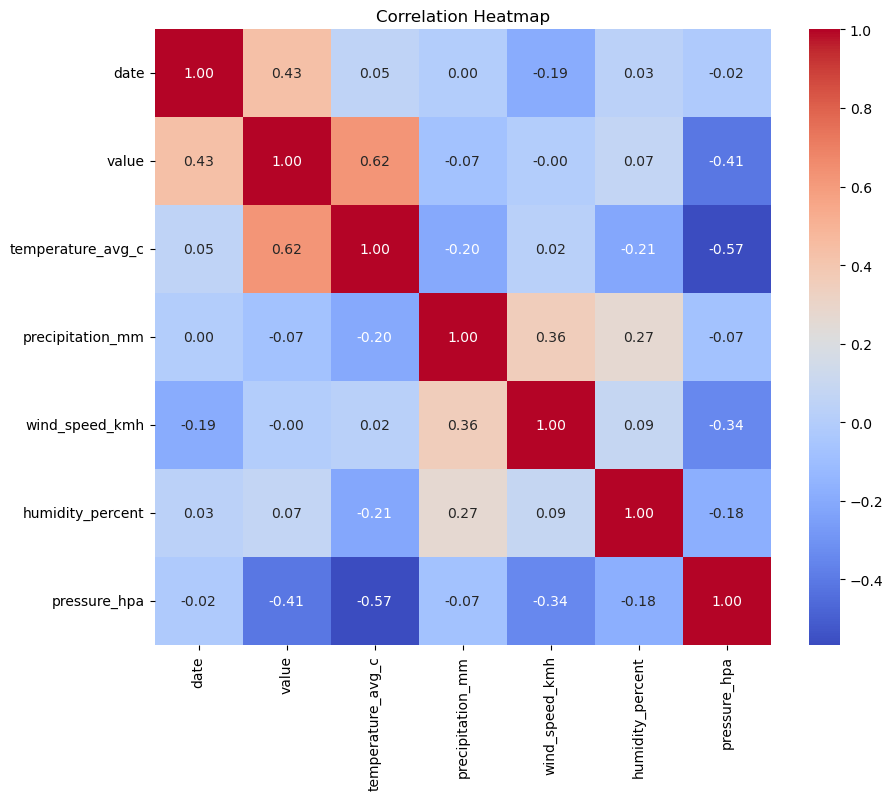

In [50]:
# Plot correlation heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = df_merged.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()


In [57]:
df_merged.rename(columns={'temperature_avg_c': 'temperature'}, inplace=True)
df = df_merged.copy()
df.set_index('date', inplace=True)
df.head()

,value,temperature,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
date,,,,,,
2019-01-01,465701,8.7,0.0,9.5,22,1019.4
2019-01-02,488901,9.1,0.0,5.3,21,1022.4
2019-01-03,484062,11.7,0.0,5.6,30,1021.5
2019-01-04,477305,12.6,0.0,6.4,38,1016.5
2019-01-05,451001,11.4,8.2,9.5,78,1014.8



Target variable is stationary (p-value: 0.0398)
Temperature variable is stationary (p-value: 0.0136)

Data split:
Training: 2019-01-01 to 2025-09-20 (2455 samples)
Testing: 2025-09-21 to 2025-09-27 (7 samples)

Using exogenous variables: ['temperature']

Starting Grid Search with Time Series Cross-Validation
Total parameter combinations: 144
Running 3-fold CV for each combination...
Running parallel evaluation with 11 cores...


/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473


Best parameters found:
  Order: (0, 0, 1)
  Seasonal Order: (0, 0, 1, 7)
  Best RMSE: 36154.875

Top 10 parameter combinations (by RMSE):
    order seasonal_order      rmse       mae  mape
(0, 0, 1)   (0, 0, 1, 7) 36154.875 29773.270 3.918
(0, 0, 1)   (0, 0, 0, 7) 36314.131 29821.478 3.925
(2, 0, 2)   (0, 0, 1, 7) 36969.829 31229.218 4.202
(0, 0, 2)   (1, 0, 0, 7) 37312.544 32815.831 4.332
(2, 0, 1)   (1, 0, 1, 7) 37707.665 32221.442 4.382
(2, 0, 0)   (1, 0, 1, 7) 37736.874 32326.357 4.406
(1, 0, 1)   (1, 0, 1, 7) 37740.066 32223.466 4.380
(1, 0, 2)   (1, 0, 1, 7) 37797.242 32245.310 4.380
(0, 0, 2)   (1, 0, 1, 7) 38430.270 34601.236 4.709
(0, 0, 2)   (0, 0, 1, 7) 38442.959 32267.388 4.270

Training Final Model with Best Parameters
                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 2455
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 7)   Log Likelihood            

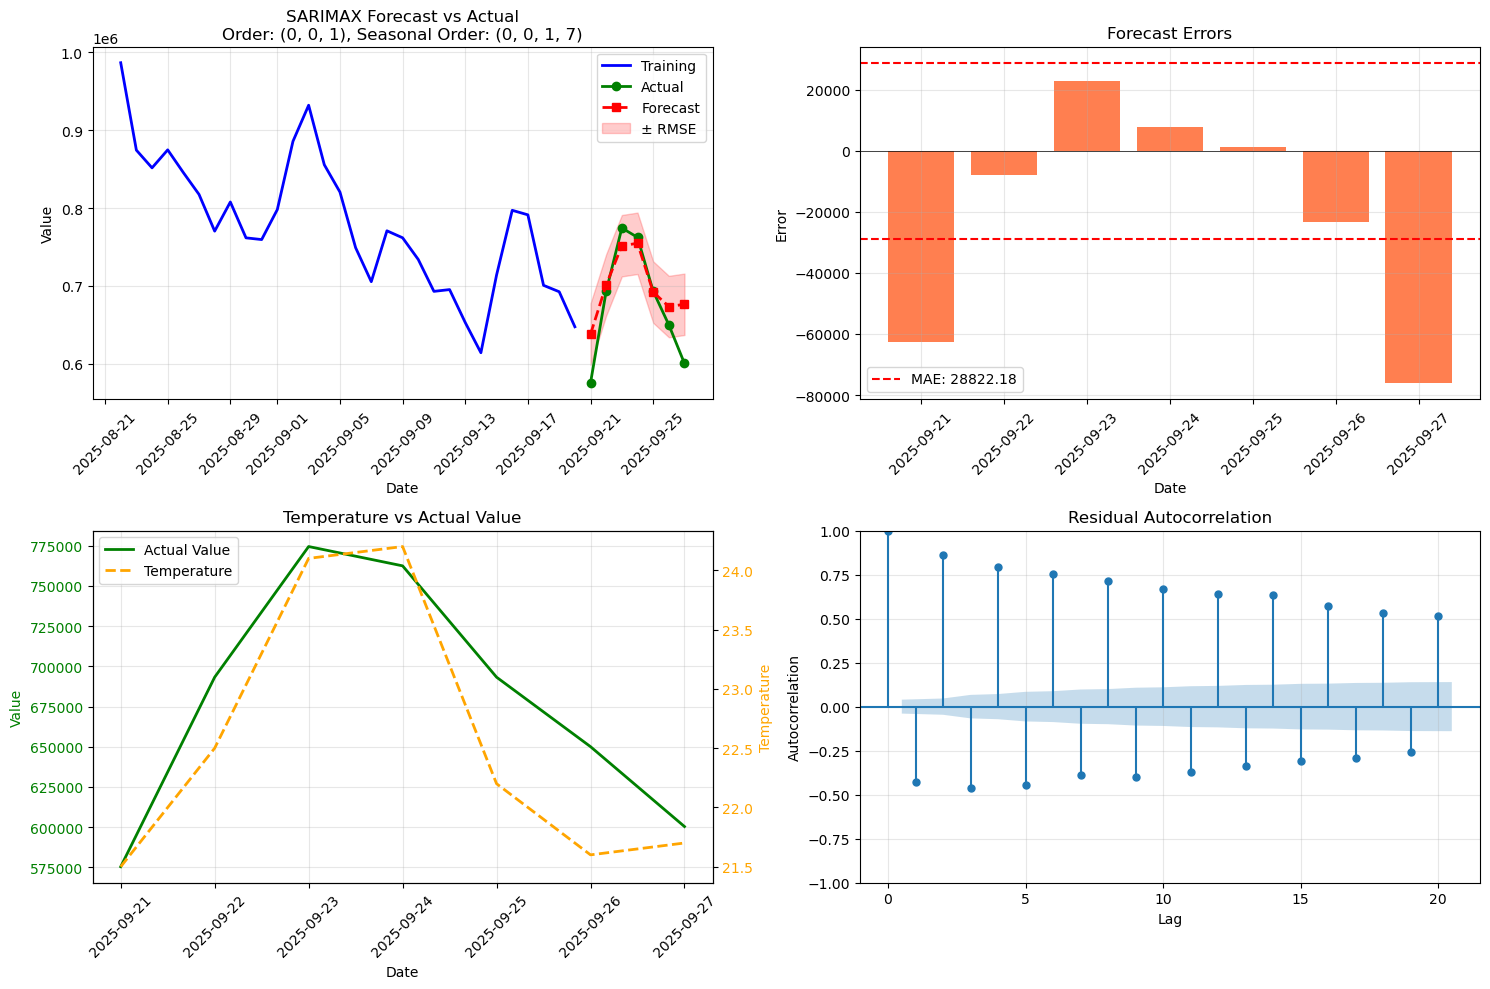


Detailed Forecast Results:
                 Date  Actual    Forecast      Error  temperature  \
date                                                                
2025-09-21 2025-09-21  575421  638036.595 -62615.595         21.5   
2025-09-22 2025-09-22  693237  701325.513  -8088.513         22.5   
2025-09-23 2025-09-23  774430  751661.479  22768.521         24.1   
2025-09-24 2025-09-24  762427  754749.587   7677.413         24.2   
2025-09-25 2025-09-25  693233  692124.556   1108.444         22.2   
2025-09-26 2025-09-26  650032  673506.506 -23474.506         21.6   
2025-09-27 2025-09-27  600388  676410.295 -76022.295         21.7   

            Error_Percent  
date                       
2025-09-21        -10.882  
2025-09-22         -1.167  
2025-09-23          2.940  
2025-09-24          1.007  
2025-09-25          0.160  
2025-09-26         -3.611  
2025-09-27        -12.662  


In [60]:

# Function to check stationarity
def check_stationarity(series):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    result = adfuller(series)
    is_stationary = result[1] <= 0.05
    return is_stationary, result[1]

# Check stationarity of target variable and exogenous variable
is_stationary, p_value = check_stationarity(df['value'])
print(f"\nTarget variable is {'stationary' if is_stationary else 'non-stationary'} (p-value: {p_value:.4f})")

if 'temperature' in df.columns:
    is_stationary_temp, p_value_temp = check_stationarity(df['temperature'])
    print(f"Temperature variable is {'stationary' if is_stationary_temp else 'non-stationary'} (p-value: {p_value_temp:.4f})")

# Time Series Cross-Validation Function for SARIMAX with exogenous variable
def time_series_cv_sarimax(data, target_col, exog_cols, order, seasonal_order, 
                          n_splits=5, test_size=7, verbose=False):
    """
    Perform time series cross-validation for SARIMAX model with exogenous variables
    """
    n_samples = len(data)
    cv_scores = {
        'mae': [],
        'mse': [],
        'rmse': [],
        'mape': []
    }
    
    # Calculate starting point for splits (ensure enough training data)
    min_train_size = n_samples - (n_splits * test_size)
    
    for i in range(n_splits):
        # Define train-test split for this fold
        test_start = min_train_size + i * test_size
        test_end = test_start + test_size
        
        train_data = data.iloc[:test_start]
        test_data = data.iloc[test_start:test_end]
        
        if verbose:
            print(f"\nFold {i+1}/{n_splits}:")
            print(f"  Train: {train_data.index[0].date()} to {train_data.index[-1].date()} "
                  f"({len(train_data)} samples)")
            print(f"  Test: {test_data.index[0].date()} to {test_data.index[-1].date()} "
                  f"({len(test_data)} samples)")
        
        try:
            # Prepare exogenous variables
            exog_train = train_data[exog_cols] if exog_cols else None
            exog_test = test_data[exog_cols] if exog_cols else None
            
            # Fit SARIMAX model with exogenous variables
            model = SARIMAX(
                train_data[target_col],
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            model_fit = model.fit(disp=False)
            
            # Forecast on test set with exogenous variables
            if exog_cols:
                forecast = model_fit.forecast(steps=len(test_data), exog=exog_test)
            else:
                forecast = model_fit.forecast(steps=len(test_data))
            
            # Calculate metrics
            actual = test_data[target_col].values
            pred = forecast.values
            
            # Handle zero values for MAPE
            mask = actual != 0
            if mask.any():
                mape = np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100
            else:
                mape = np.nan
            
            mae = mean_absolute_error(actual, pred)
            mse = mean_squared_error(actual, pred)
            rmse = np.sqrt(mse)
            
            cv_scores['mae'].append(mae)
            cv_scores['mse'].append(mse)
            cv_scores['rmse'].append(rmse)
            cv_scores['mape'].append(mape)
            
            if verbose:
                print(f"  MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%")
                
        except Exception as e:
            if verbose:
                print(f"  Error in fold {i+1}: {str(e)}")
            # Assign high error scores for failed fits
            cv_scores['mae'].append(np.inf)
            cv_scores['mse'].append(np.inf)
            cv_scores['rmse'].append(np.inf)
            cv_scores['mape'].append(np.inf)
    
    # Calculate average scores
    avg_scores = {}
    for metric in cv_scores:
        valid_scores = [score for score in cv_scores[metric] if not np.isinf(score)]
        if valid_scores:
            avg_scores[metric] = np.mean(valid_scores)
        else:
            avg_scores[metric] = np.inf
    
    return avg_scores

# Grid Search Function with Parallel Processing
def grid_search_sarimax(data, target_col, exog_cols,
                       p_range, d_range, q_range,
                       P_range, D_range, Q_range, s_values,
                       n_splits=3, test_size=7,
                       metric='rmse', n_jobs=-1,
                       verbose=1):
    """
    Perform grid search for SARIMAX hyperparameters with parallel processing
    """
    # Generate all parameter combinations
    non_seasonal_params = list(itertools.product(p_range, d_range, q_range))
    seasonal_params = list(itertools.product(P_range, D_range, Q_range))
    
    all_params = []
    for ns in non_seasonal_params:
        for ss in seasonal_params:
            for s in s_values:
                all_params.append((ns, ss, s))
    
    if verbose >= 1:
        print(f"Total parameter combinations: {len(all_params)}")
        print(f"Running {n_splits}-fold CV for each combination...")
    
    # Function to evaluate a single parameter set
    def evaluate_params(params):
        order, seasonal, s = params
        P, D, Q = seasonal
        seasonal_order = (P, D, Q, s)
        
        try:
            scores = time_series_cv_sarimax(
                data, target_col, exog_cols,
                order, seasonal_order,
                n_splits=n_splits,
                test_size=test_size,
                verbose=False
            )
            
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'mae': scores['mae'],
                'mse': scores['mse'],
                'rmse': scores['rmse'],
                'mape': scores['mape'],
                'success': True
            }
        except Exception as e:
            if verbose >= 2:
                print(f"Failed for params {order}, {seasonal_order}: {str(e)[:50]}...")
            return {
                'order': order,
                'seasonal_order': seasonal_order,
                'mae': np.inf,
                'mse': np.inf,
                'rmse': np.inf,
                'mape': np.inf,
                'success': False
            }
    
    # Run evaluations in parallel
    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()
    
    if verbose >= 1:
        print(f"Running parallel evaluation with {n_jobs} cores...")
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_params)(params) for params in all_params
    )
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter out failed runs
    valid_results = results_df[results_df['success']]
    
    if len(valid_results) == 0:
        print("Warning: No successful model fits!")
        return results_df, None
    
    # Find best parameters based on chosen metric
    if metric in valid_results.columns:
        best_idx = valid_results[metric].idxmin()
        best_params = {
            'order': valid_results.loc[best_idx, 'order'],
            'seasonal_order': valid_results.loc[best_idx, 'seasonal_order'],
            'score': valid_results.loc[best_idx, metric]
        }
        
        if verbose >= 1:
            print(f"\nBest parameters found:")
            print(f"  Order: {best_params['order']}")
            print(f"  Seasonal Order: {best_params['seasonal_order']}")
            print(f"  Best {metric.upper()}: {best_params['score']:.3f}")
    
    return results_df, best_params

# Split data for final evaluation
test_size = 7
train_data = df.iloc[:-test_size]
test_data = df.iloc[-test_size:]

print(f"\nData split:")
print(f"Training: {train_data.index[0].date()} to {train_data.index[-1].date()} "
      f"({len(train_data)} samples)")
print(f"Testing: {test_data.index[0].date()} to {test_data.index[-1].date()} "
      f"({len(test_data)} samples)")

# Define exogenous variables
exog_cols = ['temperature'] if 'temperature' in df.columns else None
if exog_cols:
    print(f"\nUsing exogenous variables: {exog_cols}")

# Perform Grid Search with CV
print("\n" + "="*60)
print("Starting Grid Search with Time Series Cross-Validation")
print("="*60)

# Define parameter ranges (keep small for demonstration)
p_range = range(0, 3)  # AR order
d_range = range(0, 2)  # Differencing
q_range = range(0, 3)  # MA order

P_range = range(0, 2)  # Seasonal AR
D_range = range(0, 2)  # Seasonal differencing
Q_range = range(0, 2)  # Seasonal MA
s_values = [7]         # Weekly seasonality

# Run grid search
results_df, best_params = grid_search_sarimax(
    data=train_data,
    target_col='value',
    exog_cols=exog_cols,
    p_range=p_range,
    d_range=d_range,
    q_range=q_range,
    P_range=P_range,
    D_range=D_range,
    Q_range=Q_range,
    s_values=s_values,
    n_splits=3,      # Number of CV folds
    test_size=7,     # Forecast horizon for CV
    metric='rmse',   # Metric to optimize
    n_jobs=-1,       # Use all cores
    verbose=1
)

# Display top 10 parameter combinations
if results_df is not None and len(results_df) > 0:
    valid_results = results_df[results_df['success']].copy()
    if len(valid_results) > 0:
        print(f"\nTop 10 parameter combinations (by RMSE):")
        top_results = valid_results.nsmallest(10, 'rmse')[['order', 'seasonal_order', 'rmse', 'mae', 'mape']]
        print(top_results.round(3).to_string(index=False))
    else:
        print("No valid results to display.")

# Train final model with best parameters
if best_params:
    print("\n" + "="*60)
    print("Training Final Model with Best Parameters")
    print("="*60)
    
    # Prepare exogenous variables for training and testing
    exog_train = train_data[exog_cols] if exog_cols else None
    exog_test = test_data[exog_cols] if exog_cols else None
    
    # Fit final model on all training data
    final_model = SARIMAX(
        train_data['value'],
        exog=exog_train,
        order=best_params['order'],
        seasonal_order=best_params['seasonal_order'],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    final_fit = final_model.fit(disp=False)
    print(final_fit.summary())
    
    # Check exogenous variables in the model
    if exog_cols:
        print(f"\nExogenous variables coefficients:")
        for i, col in enumerate(exog_cols):
            print(f"  {col}: {final_fit.params[f'{col}']:.4f}")
    
    # Forecast on test set
    if exog_cols:
        test_forecast = final_fit.forecast(steps=len(test_data), exog=exog_test)
    else:
        test_forecast = final_fit.forecast(steps=len(test_data))
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'Date': test_data.index,
        'Actual': test_data['value'],
        'Forecast': test_forecast.values,
        'Error': test_data['value'] - test_forecast.values
    })
    
    if exog_cols:
        for col in exog_cols:
            forecast_df[col] = test_data[col].values
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(forecast_df['Actual'], forecast_df['Forecast'])
    mse = mean_squared_error(forecast_df['Actual'], forecast_df['Forecast'])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(forecast_df['Error'] / forecast_df['Actual'])) * 100
    
    print(f"\nFinal Model Performance on Test Set:")
    print(f"MAE:  {mae:.3f}")
    print(f"MSE:  {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Forecast vs Actual
    axes[0, 0].plot(train_data.index[-30:], train_data['value'][-30:], 
                   label='Training', color='blue', linewidth=2)
    axes[0, 0].plot(forecast_df['Date'], forecast_df['Actual'], 
                   label='Actual', color='green', marker='o', linewidth=2)
    axes[0, 0].plot(forecast_df['Date'], forecast_df['Forecast'], 
                   label='Forecast', color='red', linestyle='--', marker='s', linewidth=2)
    axes[0, 0].fill_between(forecast_df['Date'],
                           forecast_df['Forecast'] - rmse,
                           forecast_df['Forecast'] + rmse,
                           alpha=0.2, color='red', label='± RMSE')
    axes[0, 0].set_title(f'SARIMAX Forecast vs Actual\nOrder: {best_params["order"]}, '
                        f'Seasonal Order: {best_params["seasonal_order"]}', fontsize=12)
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Forecast Errors
    axes[0, 1].bar(forecast_df['Date'], forecast_df['Error'], color='coral')
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].axhline(y=mae, color='red', linestyle='--', label=f'MAE: {mae:.2f}')
    axes[0, 1].axhline(y=-mae, color='red', linestyle='--')
    axes[0, 1].set_title('Forecast Errors', fontsize=12)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Error')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Temperature vs Value (if temperature exists)
    if exog_cols and 'temperature' in exog_cols:
        ax2 = axes[1, 0].twinx()
        axes[1, 0].plot(forecast_df['Date'], forecast_df['Actual'], 
                       label='Actual Value', color='green', linewidth=2)
        ax2.plot(forecast_df['Date'], forecast_df['temperature'], 
                label='Temperature', color='orange', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Value', color='green')
        ax2.set_ylabel('Temperature', color='orange')
        axes[1, 0].tick_params(axis='y', labelcolor='green')
        ax2.tick_params(axis='y', labelcolor='orange')
        axes[1, 0].set_title('Temperature vs Actual Value', fontsize=12)
        lines1, labels1 = axes[1, 0].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axes[1, 0].legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].tick_params(axis='x', rotation=45)
    else:
        # Residual Diagnostics
        residuals = final_fit.resid
        axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
        axes[1, 0].axvline(x=residuals.mean(), color='red', linestyle='--', 
                          label=f'Mean: {residuals.mean():.3f}')
        axes[1, 0].axvline(x=residuals.std(), color='green', linestyle='--', 
                          label=f'Std: {residuals.std():.3f}')
        axes[1, 0].set_title('Residual Distribution', fontsize=12)
        axes[1, 0].set_xlabel('Residual')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: ACF of Residuals
    from statsmodels.graphics.tsaplots import plot_acf
    residuals = final_fit.resid
    plot_acf(residuals, lags=20, ax=axes[1, 1])
    axes[1, 1].set_title('Residual Autocorrelation', fontsize=12)
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display detailed forecast table
    print("\nDetailed Forecast Results:")
    forecast_df['Error_Percent'] = (forecast_df['Error'] / forecast_df['Actual']) * 100
    print(forecast_df.round(3))

One thing to note is that we are assuming the actual temperature for the 7 days ahead forecast is unknown and we are using forecasted temperature values

## 30 Day Forecast

In [62]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [63]:
import holidays

us_holidays = holidays.US()

# Check a specific date
print('2024-07-04' in us_holidays)  # True

# List holidays for a year
for date, name in us_holidays.items():
    if date.year == 2024:
        print(date, name)

True
2024-01-01 New Year's Day
2024-05-27 Memorial Day
2024-06-19 Juneteenth National Independence Day
2024-07-04 Independence Day
2024-09-02 Labor Day
2024-11-11 Veterans Day
2024-11-28 Thanksgiving Day
2024-12-25 Christmas Day
2024-01-15 Martin Luther King Jr. Day
2024-02-19 Washington's Birthday
2024-10-14 Columbus Day


In [64]:
# Implement more advanced features
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_holiday'] = df.index.isin(holidays.US(years=range(2019, 2026))).astype(int)

In [65]:
df.head()

,value,temperature,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa,month,day_of_week,is_weekend,is_holiday
date,,,,,,,,,,
2019-01-01,465701,8.7,0.0,9.5,22,1019.4,1,1,0,1
2019-01-02,488901,9.1,0.0,5.3,21,1022.4,1,2,0,0
2019-01-03,484062,11.7,0.0,5.6,30,1021.5,1,3,0,0
2019-01-04,477305,12.6,0.0,6.4,38,1016.5,1,4,0,0
2019-01-05,451001,11.4,8.2,9.5,78,1014.8,1,5,1,0


In [66]:
df.drop(columns=['precipitation_mm', 'wind_speed_kmh','humidity_percent','pressure_hpa'], inplace=True)

In [67]:
df.head()

,value,temperature,month,day_of_week,is_weekend,is_holiday
date,,,,,,
2019-01-01,465701,8.7,1,1,0,1
2019-01-02,488901,9.1,1,2,0,0
2019-01-03,484062,11.7,1,3,0,0
2019-01-04,477305,12.6,1,4,0,0
2019-01-05,451001,11.4,1,5,1,0


In [70]:
# Create HDD and CDD features
def calculate_hdd_cdd(temp_series, heating_base_temp=18.0, cooling_base_temp=22.0):
    """Calculate Heating Degree Days (HDD) and Cooling Degree Days (CDD)"""
    hdd = np.maximum(0, heating_base_temp - temp_series)
    cdd = np.maximum(0, temp_series - cooling_base_temp)
    return hdd, cdd
df['HDD'], df['CDD'] = calculate_hdd_cdd(df['temperature'])
df.head()


,value,temperature,is_weekend,is_holiday,HDD,CDD,month_sin,month_cos,day_of_week_sin,day_of_week_cos
date,,,,,,,,,,
2019-01-01,465701,8.7,0,1,9.3,0.0,0.5,0.866025,0.781831,0.623490
2019-01-02,488901,9.1,0,0,8.9,0.0,0.5,0.866025,0.974928,-0.222521
2019-01-03,484062,11.7,0,0,6.3,0.0,0.5,0.866025,0.433884,-0.900969
2019-01-04,477305,12.6,0,0,5.4,0.0,0.5,0.866025,-0.433884,-0.900969
2019-01-05,451001,11.4,1,0,6.6,0.0,0.5,0.866025,-0.974928,-0.222521


In [69]:
# Create cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
# Drop original month and day_of_week columns
df.drop(columns=['month', 'day_of_week'], inplace=True)
df.head()

,value,temperature,is_weekend,is_holiday,HDD,CDD,month_sin,month_cos,day_of_week_sin,day_of_week_cos
date,,,,,,,,,,
2019-01-01,465701,8.7,0,1,9.3,0.0,0.5,0.866025,0.781831,0.623490
2019-01-02,488901,9.1,0,0,8.9,0.0,0.5,0.866025,0.974928,-0.222521
2019-01-03,484062,11.7,0,0,6.3,0.0,0.5,0.866025,0.433884,-0.900969
2019-01-04,477305,12.6,0,0,5.4,0.0,0.5,0.866025,-0.433884,-0.900969
2019-01-05,451001,11.4,1,0,6.6,0.0,0.5,0.866025,-0.974928,-0.222521


In [71]:
# Create Day of Year cyclical features
df['day_of_year'] = df.index.dayofyear
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df.drop(columns=['day_of_year'], inplace=True)
df.head()

,value,temperature,is_weekend,is_holiday,HDD,CDD,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos
date,,,,,,,,,,,,
2019-01-01,465701,8.7,0,1,9.3,0.0,0.5,0.866025,0.781831,0.623490,0.017213,0.999852
2019-01-02,488901,9.1,0,0,8.9,0.0,0.5,0.866025,0.974928,-0.222521,0.034422,0.999407
2019-01-03,484062,11.7,0,0,6.3,0.0,0.5,0.866025,0.433884,-0.900969,0.051620,0.998667
2019-01-04,477305,12.6,0,0,5.4,0.0,0.5,0.866025,-0.433884,-0.900969,0.068802,0.997630
2019-01-05,451001,11.4,1,0,6.6,0.0,0.5,0.866025,-0.974928,-0.222521,0.085965,0.996298


In [72]:
df.columns

Index(['value', 'temperature', 'is_weekend', 'is_holiday', 'HDD', 'CDD',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'day_of_year_sin', 'day_of_year_cos'],
      dtype='object')

In [81]:
# train,test split with latest 30 days as test set
TEST_HORIZON = 30
features = [
    'temperature', 'is_weekend', 'is_holiday',
    'HDD', 'CDD',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'day_of_year_sin', 'day_of_year_cos'
]

train_df = df.iloc[:-TEST_HORIZON]
test_df  = df.iloc[-TEST_HORIZON:]

X_train = train_df[features]
y_train = train_df['value']

X_test = test_df[features]
y_test = test_df['value']

In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb

tscv = TimeSeriesSplit(n_splits=5)

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [92]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    feature_weights=None, gamma=No...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 5, 7], 'n_estimators': [300, 500],
                         'subsample': [0.5, 0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [93]:
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

Best Parameters:
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


In [94]:
# Retrain best model on full training data
best_model.fit(df[features], df['value'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [95]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"30-Day Test RMSE: {rmse:.2f}")
print(f"30-Day Test MAE: {mae:.2f}")

30-Day Test RMSE: 58212.55
30-Day Test MAE: 49332.93


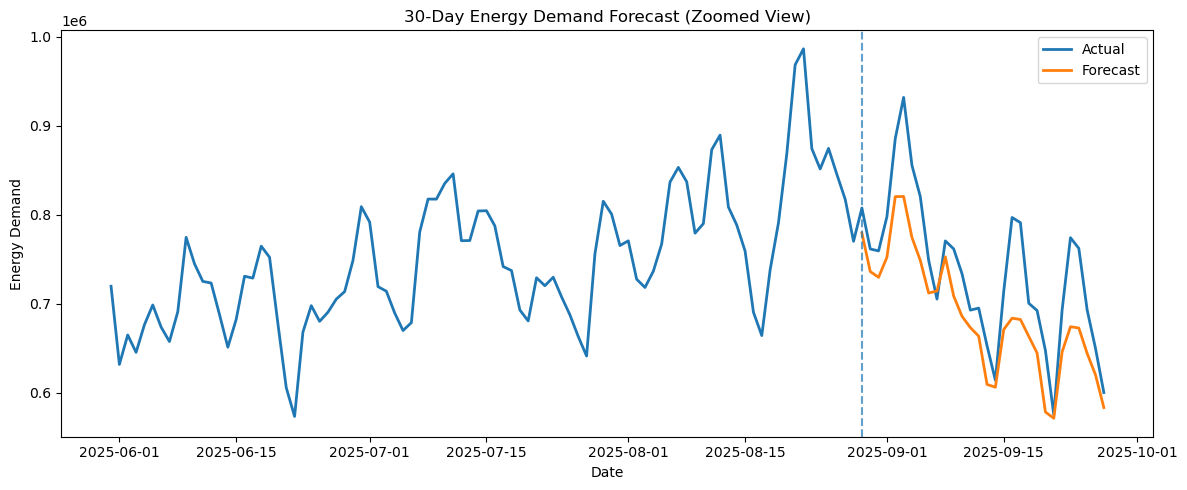

In [96]:
# Number of days to visualize
plot_days = 120

# Get index slices
plot_start = df.index[-plot_days]
actual_series = df.loc[plot_start:, 'value']

# Build prediction series with same index as test set
pred_series = pd.Series(
    y_pred,
    index=y_test.index,
    name="Forecast"
)

plt.figure(figsize=(12, 5))
plt.plot(actual_series.index, actual_series, label="Actual", linewidth=2)
plt.plot(pred_series.index, pred_series, label="Forecast", linewidth=2)

# Mark forecast start
plt.axvline(y_test.index[0], linestyle="--", alpha=0.7)

plt.title("30-Day Energy Demand Forecast (Zoomed View)")
plt.xlabel("Date")
plt.ylabel("Energy Demand")
plt.legend()
plt.tight_layout()
plt.show()

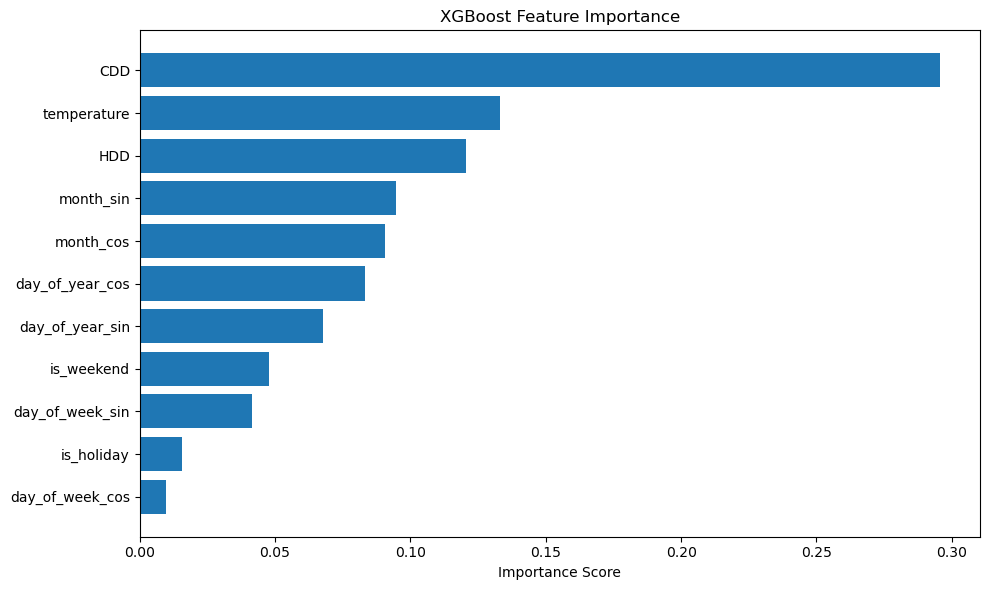

In [97]:
# Get importance scores
importance = best_model.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()

plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()